# PAE sampling and Laplace evidence calculation in u-space

In [1]:
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rcParams
import sys
import pickle
from functools import partial
import time
from tqdm import tqdm

plt.rcParams.update({'font.family' : 'lmodern', 'font.size': 16,                                                                                                                                                    
                     'axes.labelsize': 16, 'legend.fontsize': 12, 
                     'xtick.labelsize': 16, 'ytick.labelsize': 16, 'axes.titlesize': 16,
                     'axes.linewidth': 1.5})

In [2]:
import scipy

In [3]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfd = tfp.distributions
tfb = tfp.bijectors
tf.__version__
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
print(tf.__version__, tfp.__version__, hub.__version__)

2.2.0 0.10.0 0.8.0


### Loading the trained modules and evaluating logp in tensorflow

In [5]:
def get_prior(latent_size):
    return tfd.MultivariateNormalDiag(tf.zeros(latent_size), scale_identity_multiplier=1.0)

In [6]:
PROJECT_PATH = ''
MODULES_PATH = os.path.join(PROJECT_PATH,'/global/cscratch1/sd/vboehm/PAE_samples/MNIST/latent_dim10/modules')
param_file   = 'params_mnist_-1_10_vae10_AE_test_full_sigma'
params       = pickle.load(open(os.path.join(MODULES_PATH,param_file+'.pkl'),'rb'))
params['module_dir']=MODULES_PATH

In [7]:
x_train, _ = tfds.as_numpy(tfds.load('mnist',split='train',batch_size=-1,as_supervised=True,))
x_test, _  = tfds.as_numpy(tfds.load('mnist',split='test',batch_size=-1,as_supervised=True,))

In [8]:
x_train = (x_train/256.-0.5).astype(np.float32)
x_test  = (x_test/256.-0.5).astype(np.float32)

In [9]:
generator_path   = os.path.join(params['module_dir'],'decoder')
encoder_path     = os.path.join(params['module_dir'],'encoder')
nvp_path         = os.path.join(params['module_dir'],'hybrid8_nepoch220')

In [10]:
def get_likelihood(decoder,sigma,nvp, mask):
    sigma = tf.reshape(sigma,(params['batch_size'],-1))
    sigma = tf.boolean_mask(sigma,mask,axis=1)
    def likelihood(u):
        z     = nvp_funcs({'z_sample':np.zeros((params['batch_size'],params['latent_size'])),'sample_size':1, 'u_sample':u})['fwd_pass']
        mean  = decoder({'z':z})['x']
        mean  = tf.reshape(mean,(params['batch_size'],-1))
        mean  = tf.boolean_mask(mean,mask,axis=1)
        LL = tfd.MultivariateNormalDiag(loc=mean,scale_diag=sigma)
        return tfd.Independent(LL)

    return likelihood

def get_prior(latent_size):
    return tfd.MultivariateNormalDiag(tf.zeros(latent_size), scale_identity_multiplier=1.0)

In [11]:
mask = np.ones((28,28))

minx = 0
maxx = 17

mask[0:28,minx:maxx]=0.
mask = mask.flatten().astype(np.float32)

In [12]:
sigma         = params['full_sigma']
sigma         = sigma.astype(np.float32)

encoder       = hub.KerasLayer(encoder_path,trainable=False, signature_outputs_as_dict=True)
decoder       = hub.KerasLayer(generator_path, trainable=False, signature_outputs_as_dict=True)
nvp_funcs     = hub.KerasLayer(nvp_path, trainable=False, signature_outputs_as_dict=True)


likelihood    = get_likelihood(decoder,np.repeat(np.expand_dims(sigma,0),params['batch_size'],axis=0),nvp_funcs, mask)
prior         = get_prior(params['latent_size'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [13]:
def build_container(z):
    filler = np.zeros((params['batch_size'],len(z)))
    filler[0] = z
    return filler

In [14]:
def get_encoded(x, nvp_funcs=nvp_funcs):
    mu, sigma        = tf.split(encoder({'x':x})['z'], 2, axis=-1)
    u                = nvp_funcs({'z_sample':mu,'sample_size':1, 'u_sample':np.zeros((params['batch_size'],params['latent_size']))})['bwd_pass']
    return u

def get_decoded(u, nvp_funcs=nvp_funcs):
    z                =  nvp_funcs({'z_sample':np.zeros((params['batch_size'],params['latent_size'])),'sample_size':1, 'u_sample':u})['fwd_pass']
    return decoder({'z':z})['x']

def likelihood_eval(u,x,likelihood,mask):
    x              = tf.boolean_mask(x, mask, axis=1)
    likelihood_    = likelihood(u).log_prob(x)
    return likelihood_

def prior_eval(u):
    prior_         = prior.log_prob(u)
    return prior_

def posterior_eval(u,x,likelihood, nvp_funcs, mask):
    x            = tf.reshape(x,(params['batch_size'],-1))
    likelihood_  = likelihood_eval(u,x,likelihood,mask)
    prior_       = prior_eval(u)
    logprob      = likelihood_+prior_

    return logprob


class LogP():
    def __init__(self,x,mask):
        self.x = x
        self.mask = mask
        self.u_fill = tf.Variable(tf.zeros((params['batch_size'],params['latent_size']),tf.float32),trainable=False)
    
    def logp_grad(self,u):

        self.u_fill.assign(u)
        u_  = tf.convert_to_tensor(self.u_fill)
        
        with tf.GradientTape() as tape:
            tape.watch(u_)
            log_p         = posterior_eval(u_,self.x,likelihood,nvp_funcs, self.mask)
        grad = tape.gradient(log_p, [u_])
        return log_p, grad[0]

    @tf.custom_gradient
    def logp(self,u):

        logp, grads = self.logp_grad(u)

        def grad(up,variables=None):
            grad_ = tf.expand_dims(up,-1)*grads

            return grad_, [None for ii in range(len(variables))] 

        return logp, grad

### Minimization to find the MAP values and Hessian computation at Minimum

In [15]:
### load or generate them
filename_truth = os.path.join('/global/cscratch1/sd/vboehm/PAE_samples/MNIST/latent_dim10/','MAPu_xtest8_masked-128_from_truth.npy')
filename_rand  = os.path.join('/global/cscratch1/sd/vboehm/PAE_samples/MNIST/latent_dim10/','MAPu_xtest8_masked-128_from_rand.npy')
# #np.save(filename,z_min)
# z_min    = np.load(filename)

x          = np.repeat(x_test[8][None,:,:], params['batch_size'], axis=0)#x_test[0:params['batch_size']]#np.repeat(, params['batch_size'], axis=0)##
z_true_ini = get_encoded(x.reshape((-1,28*28)))

# # filename = os.path.join(PROJECT_PATH,'PAE_samples/FMNIST/latent_dim32/PAE/samples','Hess_uspace_xtest0-128.npy')
# # #np.save(filename,h)
z_true = np.load(filename_truth)
z_rand = np.load(filename_rand)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [16]:
optimizer       = tf.keras.optimizers.Adam(learning_rate=0.01)
losses          = []

x               = np.repeat(x_test[8][None,:,:], params['batch_size'], axis=0)##Neural Network based equations solvers
masked_x        = x*mask.reshape((28,28))[None,:,:,None]


#needs at least 2400 minimization to converge for random sarting values
LP              = LogP(masked_x,mask)
z_ini           = z_true_ini#np.random.randn(params['batch_size'],params['latent_size']).astype(np.float32)#z_true_ini#

# z_var           = tf.Variable(z_ini)
# for iteration in tqdm(range(4000)):
#     optimizer.minimize(lambda: -tf.reduce_sum(LP.logp(z_var)), var_list=[z_var])
#     loss  = -LP.logp(z_var)
#     losses.append(loss)

In [34]:
z_min = tf.convert_to_tensor(z_var)
z_true= tf.convert_to_tensor(z_min)

In [35]:
losses = np.asarray(losses)

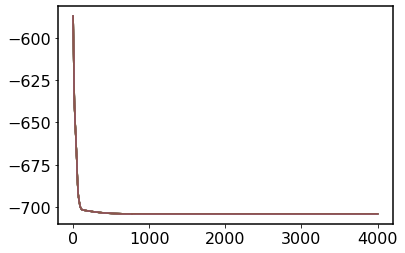

In [36]:
plt.plot(losses)
plt.show()

In [18]:
logp_z_true_ini = LP.logp(z_true_ini) 
logp_z_true = LP.logp(z_true) 
logp_z_rand = LP.logp(z_rand) 

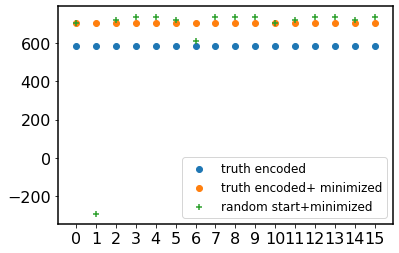

In [19]:
plt.scatter(np.arange(16),logp_z_true_ini, label ='truth encoded')
plt.scatter(np.arange(16),logp_z_true, label ='truth encoded+ minimized')
plt.scatter(np.arange(16),logp_z_rand, label ='random start+minimized', marker='+')
plt.xticks(np.arange(16))
plt.legend()

In [20]:
np.where(logp_z_rand<logp_z_true)


(array([1, 6]),)

In [21]:
np.save(filename_truth,z_true)
np.save(filename_rand,z_rand)

In [22]:
recon_truth = np.reshape((get_decoded(z_true, nvp_funcs)),(-1,28,28))
recon_ini  = np.reshape((get_decoded(z_true_ini, nvp_funcs)),(-1,28,28))
recon_rand = np.reshape((get_decoded(z_rand, nvp_funcs)),(-1,28,28))

In [42]:
x.shape

(16, 28, 28, 1)

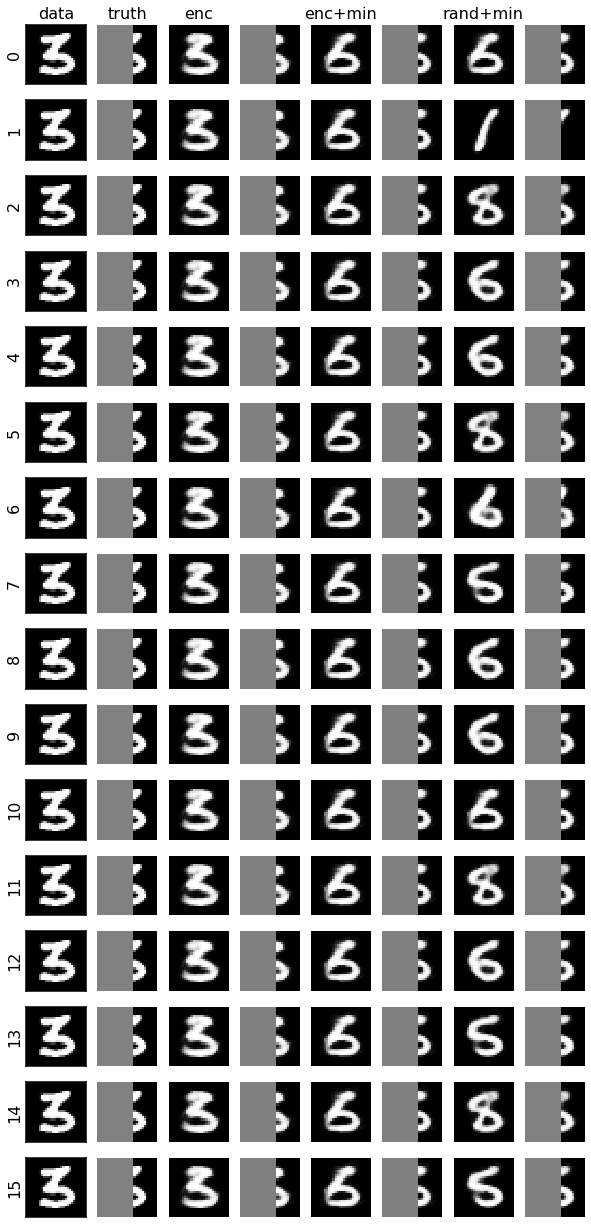

In [43]:
fig, ax = plt.subplots(nrows=16, ncols=8, figsize=(10,22))

fig.patch.set_facecolor('xkcd:white')
for ii in range(params['batch_size']):
    #plt.subplot(params['batch_size'],2,ii*2+1)
    
    if ii==0:
        ax[ii][0].set_title('data')
        ax[ii][1].set_title('truth')
        ax[ii][2].set_title('enc')
#        ax[ii][3].set_title('recon enc')
        ax[ii][4].set_title('enc+min')
#        ax[ii][5].set_title('recon ')
        ax[ii][6].set_title('rand+min')
#        ax[ii][7].set_title('recon masked')        
        
    ax[ii][0].imshow(np.squeeze(x[ii]),cmap='gray')
    ax[ii][0].set_ylabel('%d'%ii)
    ax[ii][0].set_yticks([])
    ax[ii][0].set_xticks([])
    #ax[ii][0].axis('off')
    
    
    ax[ii][1].imshow(np.squeeze(masked_x[ii]),cmap='gray')
    ax[ii][1].axis('off')
    
    #plt.subplot(params['batch_size'],2,ii*2+2)
    ax[ii][2].imshow(recon_ini[ii],cmap='gray')
    ax[ii][2].axis('off')
    
    ax[ii][3].imshow(recon_ini[ii]*mask.reshape((28,28)),cmap='gray')
    ax[ii][3].axis('off')

    #plt.subplot(params['batch_size'],2,ii*2+2)
    ax[ii][4].imshow(recon_truth[ii],cmap='gray')
    ax[ii][4].axis('off')
    
    ax[ii][5].imshow(recon_truth[ii]*mask.reshape((28,28)),cmap='gray')
    ax[ii][5].axis('off')
    

    
    #plt.subplot(params['batch_size'],2,ii*2+2)
    ax[ii][6].imshow(recon_rand[ii],cmap='gray')
    ax[ii][6].axis('off')
    
    ax[ii][7].imshow(recon_rand[ii]*mask.reshape((28,28)),cmap='gray')
    ax[ii][7].axis('off')

plt.gca().axes.get_yaxis().set_visible(True)
    
# plt.subplots_adjust(left=0.125,
#                     bottom=0.1, 
#                     right=0.9, 
#                     top=0.9, 
#                     wspace=0.01, 
#                     hspace=0.01)

### NUTS sampling

In [17]:
burnin     = 300
ntreelevel = 7
#filename   = os.path.join('/global/cscratch1/sd/vboehm/PAE_samples/MNIST/latent_dim10/','NUTS_MNISTuspace_masked_latent_dim%d_burnin%d_ntreelevel%d_1batch2000.npy'%(params['latent_size'], burnin, ntreelevel))

In [ ]:
import time

In [ ]:
initial_step_size = np.ones((params['batch_size'],params['latent_size']))*0.02

In [ ]:
# Initialize the HMC transition kernel.
num_results = int(2000)
print(num_results)

def get_kernel(ii,num_burnin_steps, ntreelevel):
    x     = x_test
    LP    = LogP(x,mask)
    z_ini = z_rand
    adaptive_hmc = tfp.mcmc.DualAveragingStepSizeAdaptation(
        tfp.mcmc.NoUTurnSampler(
            target_log_prob_fn=LP.logp,max_tree_depth=ntreelevel,
            #num_leapfrog_steps=num_lp_steps,
            step_size=initial_step_size),
            num_adaptation_steps=int(num_burnin_steps * 0.8))
    return adaptive_hmc, z_ini, LP
#         tfp.mcmc.HamiltonianMonteCarlo(
#             target_log_prob_fn=LP.logp,
#             num_leapfrog_steps=num_lp_steps,
#             step_size=initial_step_size),
#             num_adaptation_steps=int(num_burnin_steps * 0.8))
    return adaptive_hmc, z_ini, LP

# Run the chain (with burn-in).
@tf.function()
def run_chain(adapative_hmc, z_ini, num_burnin_steps):
  # Run the chain (with burn-in).
    samples, [step_size, accept_ratio, leapfrogs] = tfp.mcmc.sample_chain(
      num_results      = num_results,
      num_burnin_steps = num_burnin_steps,
      current_state    = z_ini,
      kernel           = adaptive_hmc,
      trace_fn         = lambda _, pkr: [pkr.inner_results.step_size,
                             pkr.inner_results.is_accepted, pkr.inner_results.leapfrogs_taken])

    return samples, step_size, accept_ratio, leapfrogs

In [ ]:
begin = time.time()
samples_ = []
for ii in range(0,1):
    print(ii)
    for jj, burnin in enumerate([300]):
        for nn, ntreelevel in enumerate([7]):
            adaptive_hmc, z_ini, LP = get_kernel(ii,burnin,ntreelevel)
            samples, step_size, accept_ratio, leapfrogs = run_chain(adaptive_hmc, tf.convert_to_tensor(z_ini),tf.constant(burnin))
            end = time.time()-begin
            print(end)
            begin = time.time()
    samples_.append(samples)

print(samples.shape)
samples = np.swapaxes(np.asarray(samples_),1,2)
print(samples.shape)
samples = np.reshape(samples,(-1,num_results,params['latent_size']))
print(samples.shape)
np.save(os.path.join(PROJECT_PATH,'/global/cscratch1/sd/vboehm/PAE_samples/MNIST/latent_dim10/','NUTS_MNISTuspace_masked_latent_dim%d_burnin%d_ntreelevel%d_1batch2000_start_minrand.npy'%(params['latent_size'],burnin,ntreelevel)),samples)
print('time:', end/60)

In [22]:
samples_=np.load(os.path.join(PROJECT_PATH,'/global/cscratch1/sd/vboehm/PAE_samples/MNIST/latent_dim10/','NUTS_MNISTuspace_masked_latent_dim%d_burnin%d_ntreelevel%d_1batch2000_start_minrand.npy'%(params['latent_size'],burnin,ntreelevel)))

In [23]:
samples_.shape

(16, 2000, 10)

In [24]:
samples = samples_.reshape(-1,10)

In [29]:
samples.shape

(32000, 10)

### Computing sample variance and information gain between posterior and prior

### plot samples (differences in between samples)

(64, 10)


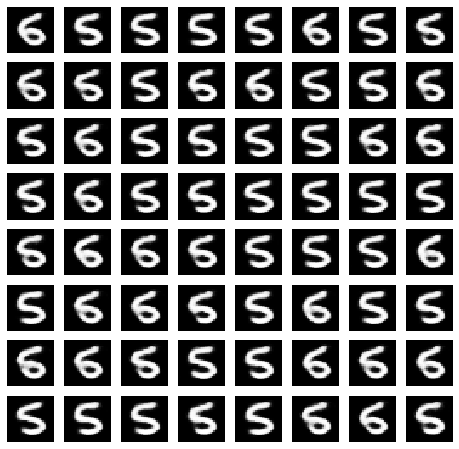

In [25]:
sub_select = np.random.choice(np.arange(2000)*16,8*8)

sub_samples = samples[sub_select]
print(sub_samples.shape)
plt.figure(figsize=(8,8))
old_fig=np.zeros((28,28))
for ii in range(8*8):
    plt.subplot(8,8,ii+1)
    fig = np.squeeze(get_decoded(build_container(sub_samples[ii]))[0])
    plt.imshow(fig.reshape((28,28)), vmin=-0.5, vmax=0.5, cmap='gray')
    old_fig=fig
    plt.axis('off')
plt.show()

### plot and inspect samples

In [26]:
import corner

In [27]:
np.concatenate((samples,samples_truth), axis=1).shape

NameError: name 'samples_truth' is not defined

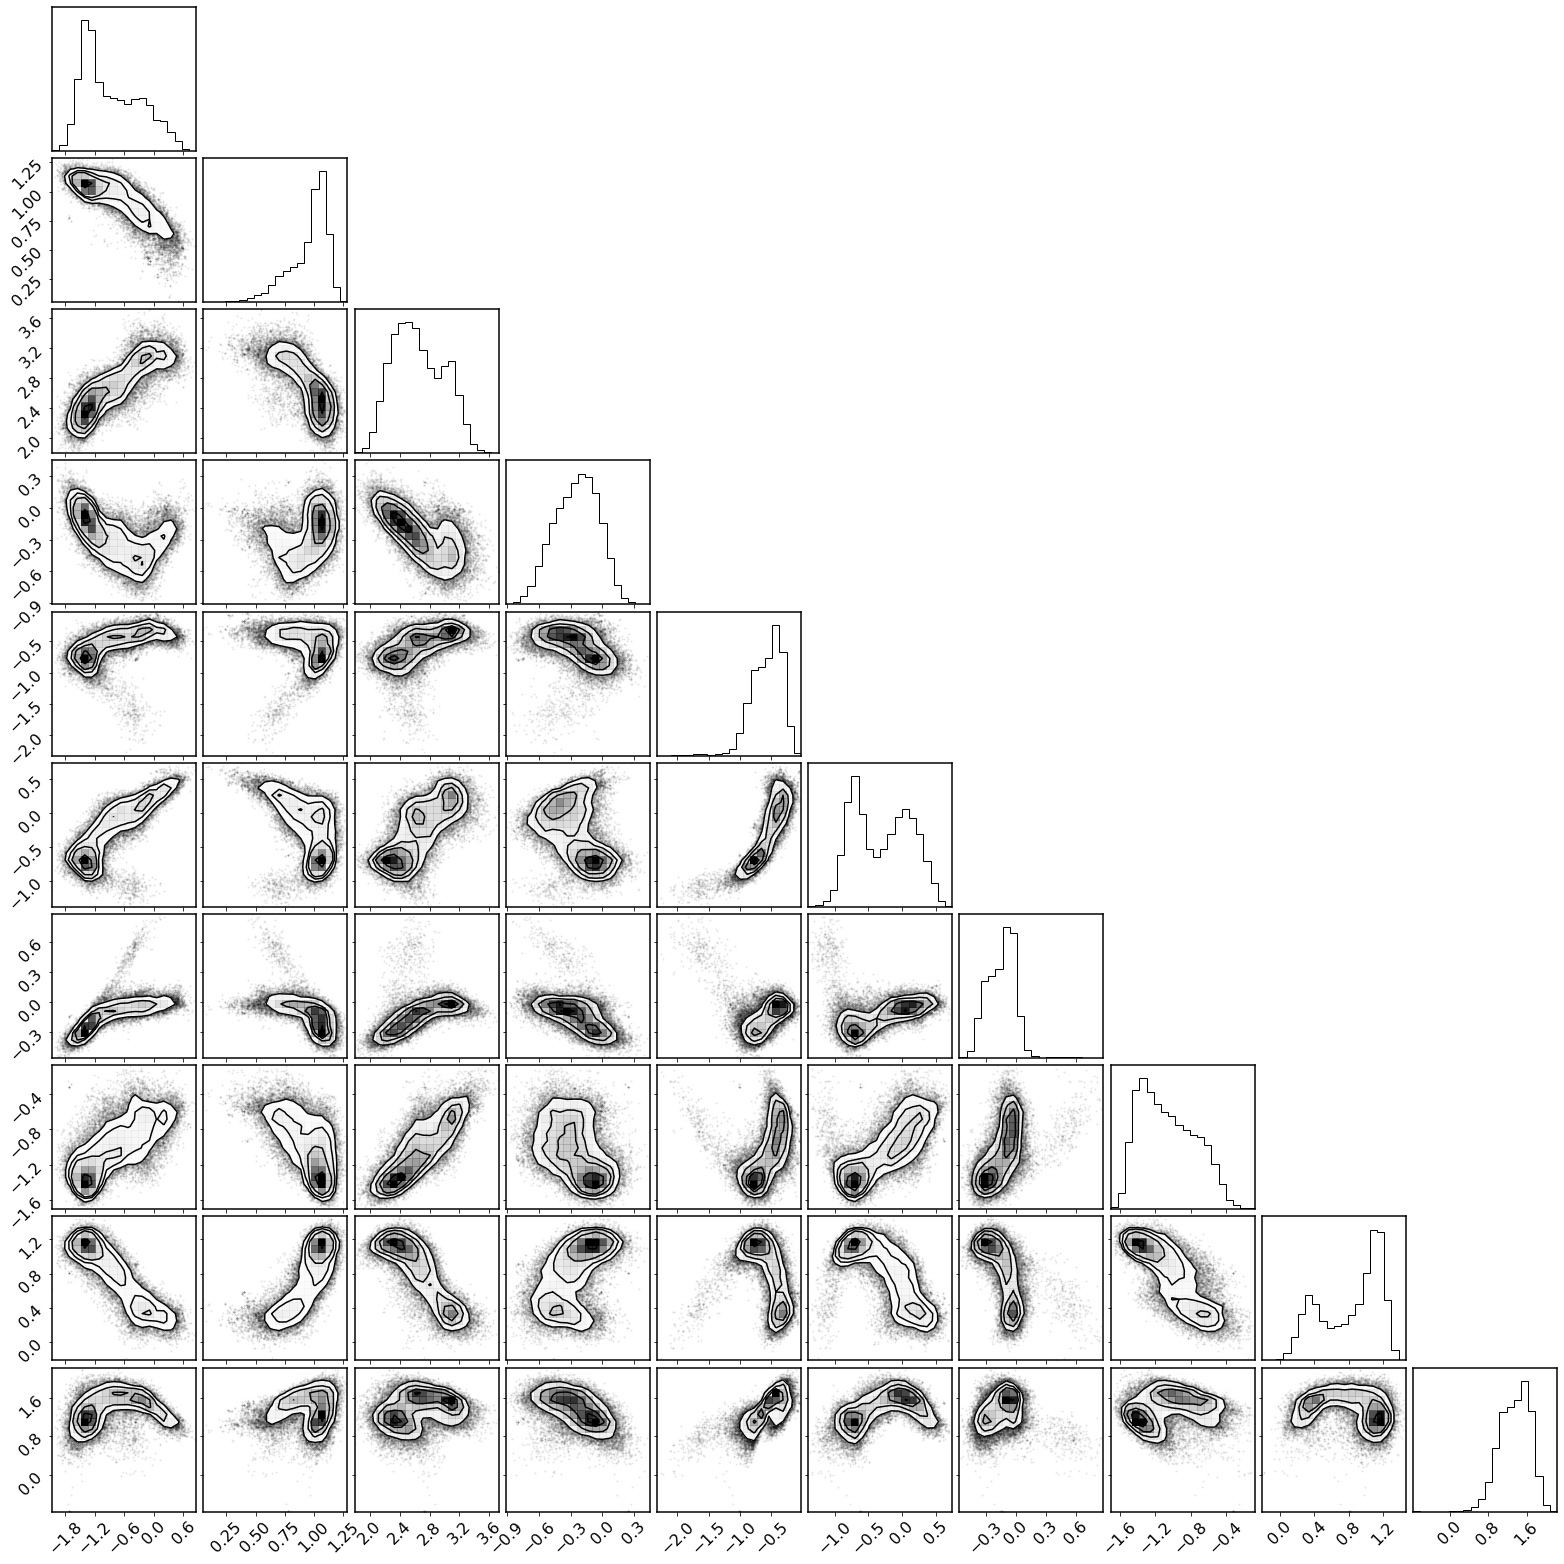

In [28]:
corner.corner(samples[:,0:10])
plt.show()

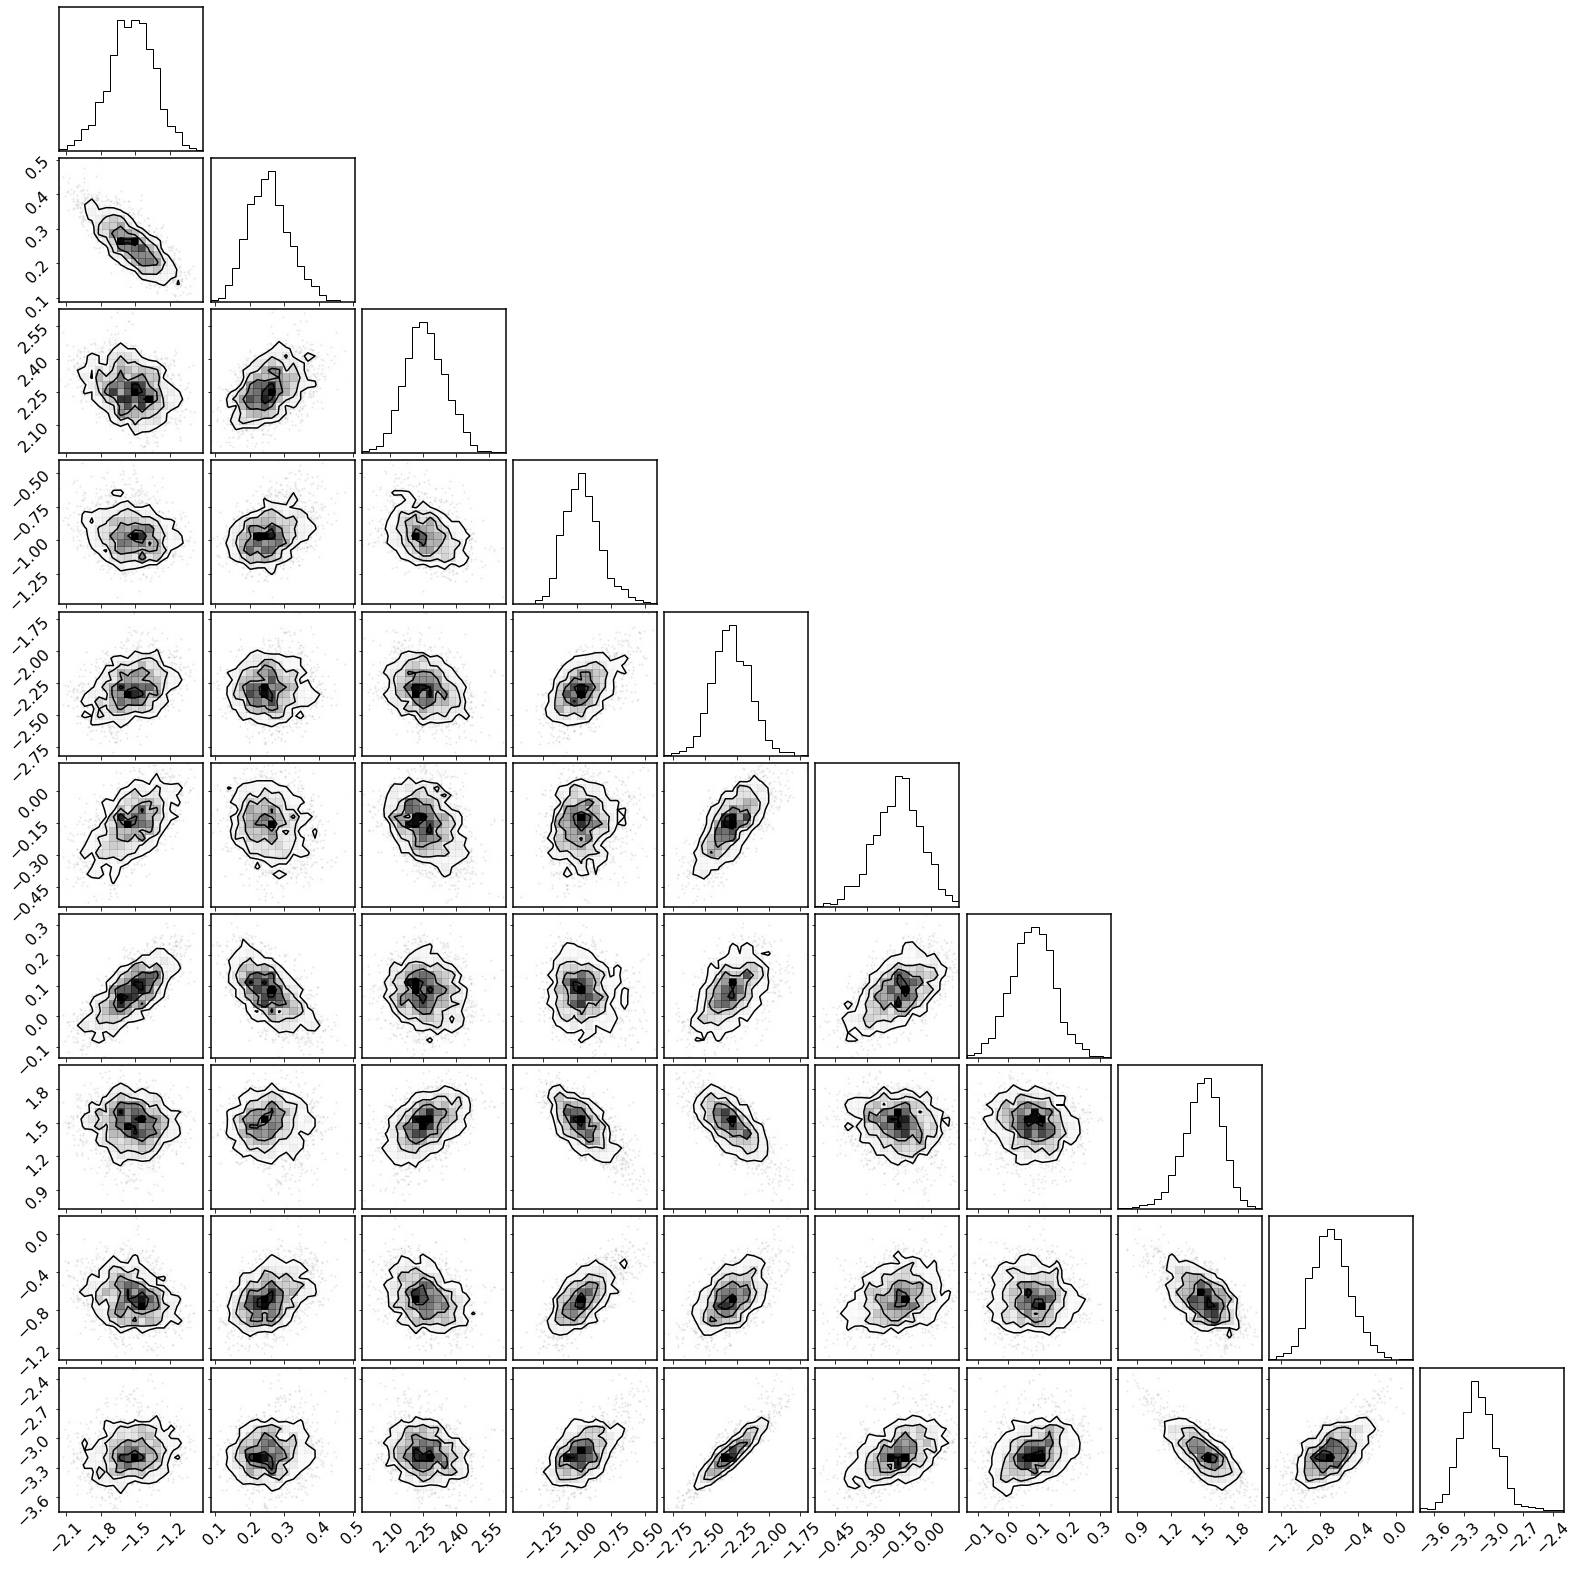

In [50]:
corner.corner(samples_truth[8,:,0:10])
plt.show()

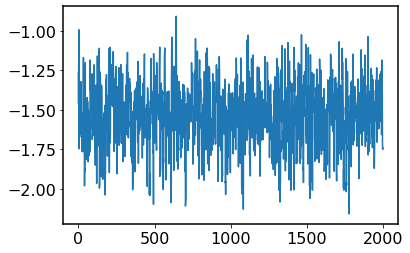

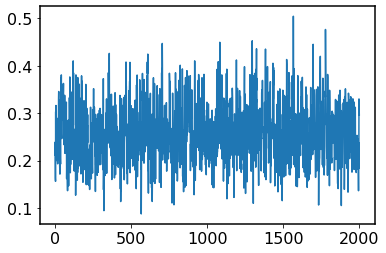

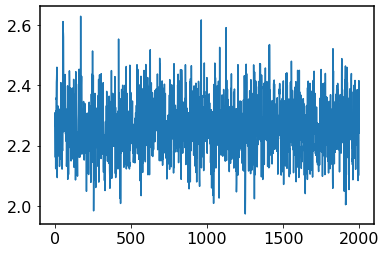

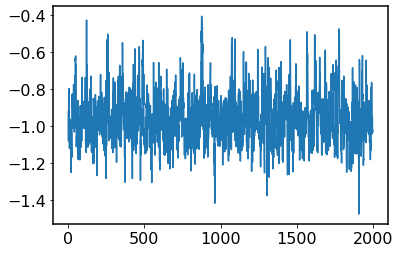

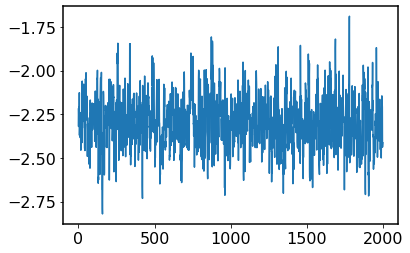

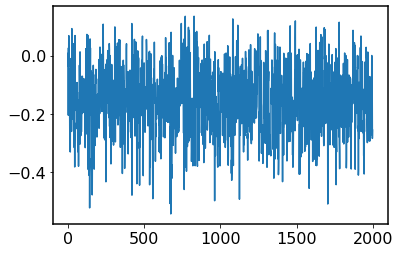

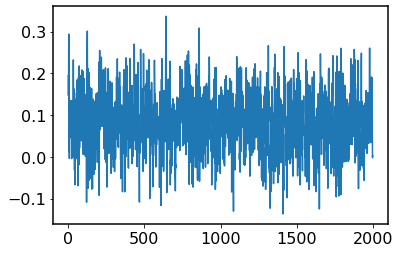

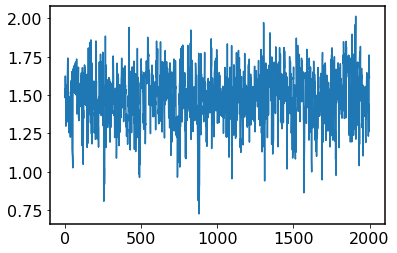

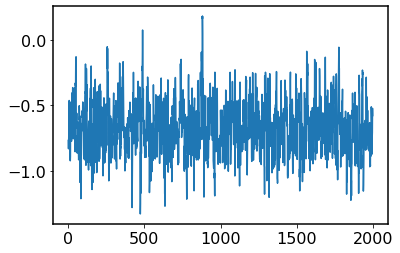

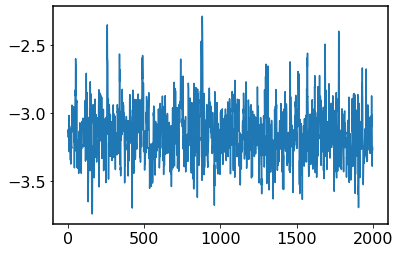

In [35]:
for ii in range(10):
    plt.plot(samples[8,:,ii])
    plt.show()

In [36]:


def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i

def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))

    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2 * n)
    acf = np.fft.ifft(f * np.conjugate(f))[: len(x)].real
    acf /= 4 * n

    # Optionally normalize
    if norm:
        acf /= acf[0]

    return acf



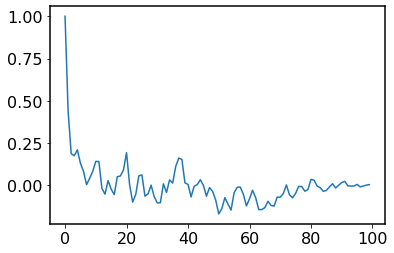

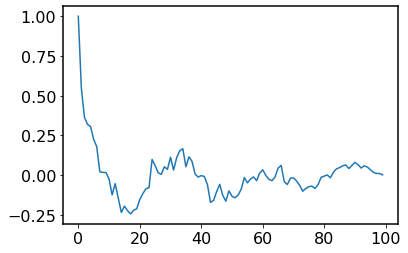

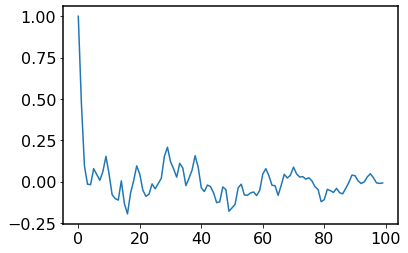

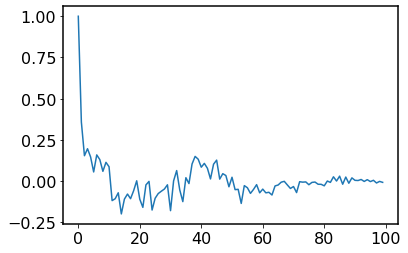

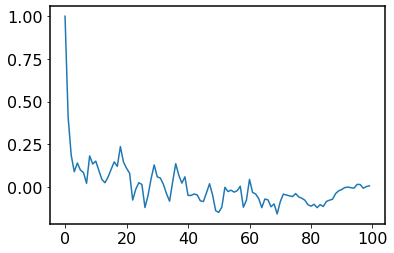

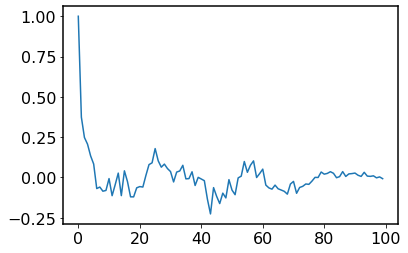

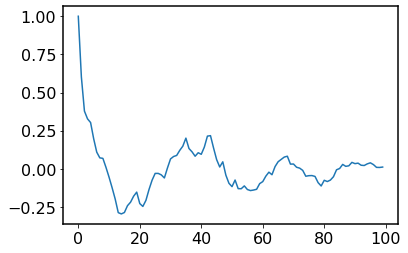

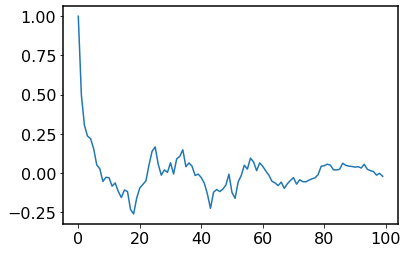

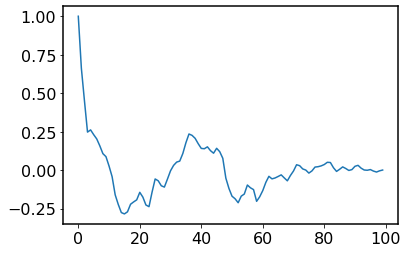

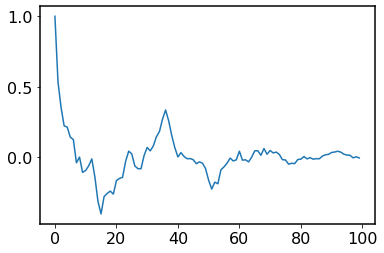

In [37]:


for ii in range(10):
    for n in [100]:
        acf = autocorr_func_1d(samples[0,:n,ii], norm=True)
        plt.plot(acf)
        plt.show()

